In [516]:
import ete3
import pandas as pd
from matplotlib import pyplot as plt
import pickle as pkl
from scipy.stats import hypergeom, binom_test, ttest_ind
import numpy as np
import math
import itertools
import seaborn as sns
import collections
import operator
from statsmodels.sandbox.stats.multicomp import multipletests
import os
%matplotlib inline
ncbi = ete3.NCBITaxa()

In [24]:
tree = pkl.load(open('species_tree_with_transferred_nodes.pkl'))
tree.write(outfile='species.tre', format=1)

In [18]:
involved_in_both = []
involved_in_any  = []
involved_in_ctrl = []
involved_in_nif  = []
total_nodes      = 0
for node in tree.traverse():
    total_nodes += 1
    ctrl_flag = True if 'control_donor' in node.features or 'control_recipient' in node.features else False
    nif_flag  = True if 'nif_donor'     in node.features or 'nif_recipient'     in node.features else False
    if ctrl_flag and nif_flag:
        involved_in_both.append(node.name)
    if ctrl_flag or nif_flag:
        involved_in_any.append(node.name)
    if ctrl_flag:
        involved_in_ctrl.append(node.name)        
    if nif_flag:
        involved_in_nif.append(node.name)

In [19]:
print total_nodes
print len(involved_in_both)
print len(involved_in_any)
print len(involved_in_ctrl)
print len(involved_in_nif)

957
157
707
703
161


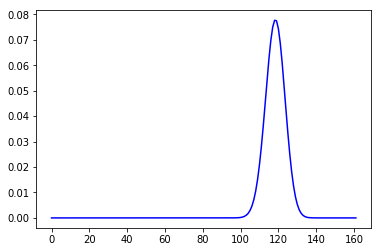

In [49]:
rv = hypergeom(total_nodes, len(involved_in_nif), len(involved_in_ctrl))
x  = range(len(involved_in_nif)+1)
y  = rv.pmf(x)
plt.plot(x,y, 'b-')

In [50]:
print rv.sf(157)
print rv.stats()

7.032552350012148e-20
(array(118.26854754), array(26.13642705))


In [557]:
assessed_classes   = 'Betaproteobacteria Gammaproteobacteria Epsilonproteobacteria Alphaproteobacteria Deltaproteobacteria'.split()
class_count = {}
for dataset in 'ctrl nif'.split():
    class_count[dataset] = {taxon:0 for taxon in assessed_classes}

for group in os.listdir('control_reconciliations'):
    if not os.path.isfile('control_reconciliations/%s/aggregated' % group):
        continue
    print group
    tree   = ete3.Tree(open('control_reconciliations/%s/%s.ranger_input' % (group, group)).readlines()[1])
    taxids = [leaf.split('_')[0] for leaf in tree.get_leaf_names()]
    observed_classes = proteo['class'][proteo.taxid.isin(taxids)].tolist()
    for taxon in assessed_classes:
        class_count['ctrl'][taxon] += observed_classes.count(taxon)
print ''
for group in os.listdir('mad_reconciliations'):
    if not os.path.isfile('mad_reconciliations/%s/aggregated' % group):
        continue
    print group
    tree   = ete3.Tree(open('mad_reconciliations/%s/%s.ranger_input' % (group, group)).readlines()[1])
    taxids = [leaf.split('_')[0] for leaf in tree.get_leaf_names()]
    observed_classes = proteo['class'][proteo.taxid.isin(taxids)].tolist()
    for taxon in assessed_classes:
        class_count['nif'][taxon] += observed_classes.count(taxon)


Proteo_1010
Proteo_1034
Proteo_1058
Proteo_106
Proteo_1157
Proteo_1245
Proteo_1514
Proteo_1530
Proteo_1596
Proteo_1639
Proteo_1698
Proteo_1760
Proteo_1764
Proteo_1771
Proteo_180
Proteo_1899
Proteo_1952
Proteo_1984
Proteo_2005
Proteo_2006
Proteo_2080
Proteo_2081
Proteo_2131
Proteo_2166
Proteo_2186
Proteo_2206
Proteo_2218
Proteo_2225
Proteo_2230
Proteo_2245
Proteo_2246
Proteo_2264
Proteo_2312
Proteo_2313
Proteo_2336
Proteo_2341
Proteo_2373
Proteo_2394
Proteo_2396
Proteo_2457
Proteo_2513
Proteo_2521
Proteo_2542
Proteo_2557
Proteo_2644
Proteo_2688
Proteo_2717
Proteo_2771
Proteo_2778
Proteo_2814
Proteo_2831
Proteo_2842
Proteo_2863
Proteo_2885
Proteo_2906
Proteo_3004
Proteo_3012
Proteo_3115
Proteo_3117
Proteo_3155
Proteo_3255
Proteo_3312
Proteo_3317
Proteo_3442
Proteo_3479
Proteo_3535
Proteo_3572
Proteo_3636
Proteo_387
Proteo_3901
Proteo_3903
Proteo_410
Proteo_4355
Proteo_4431
Proteo_4530
Proteo_454
Proteo_4593
Proteo_4657
Proteo_4693
Proteo_478
Proteo_4806
Proteo_4977
Proteo_5209
Proteo_53


In [558]:
class_count

{'ctrl': {'Alphaproteobacteria': 5390,
  'Betaproteobacteria': 2819,
  'Deltaproteobacteria': 2610,
  'Epsilonproteobacteria': 926,
  'Gammaproteobacteria': 3381},
 'nif': {'Alphaproteobacteria': 693,
  'Betaproteobacteria': 639,
  'Deltaproteobacteria': 314,
  'Epsilonproteobacteria': 183,
  'Gammaproteobacteria': 899}}

Ttest_indResult(statistic=-4.8585036237375485, pvalue=3.069744141882498e-06)


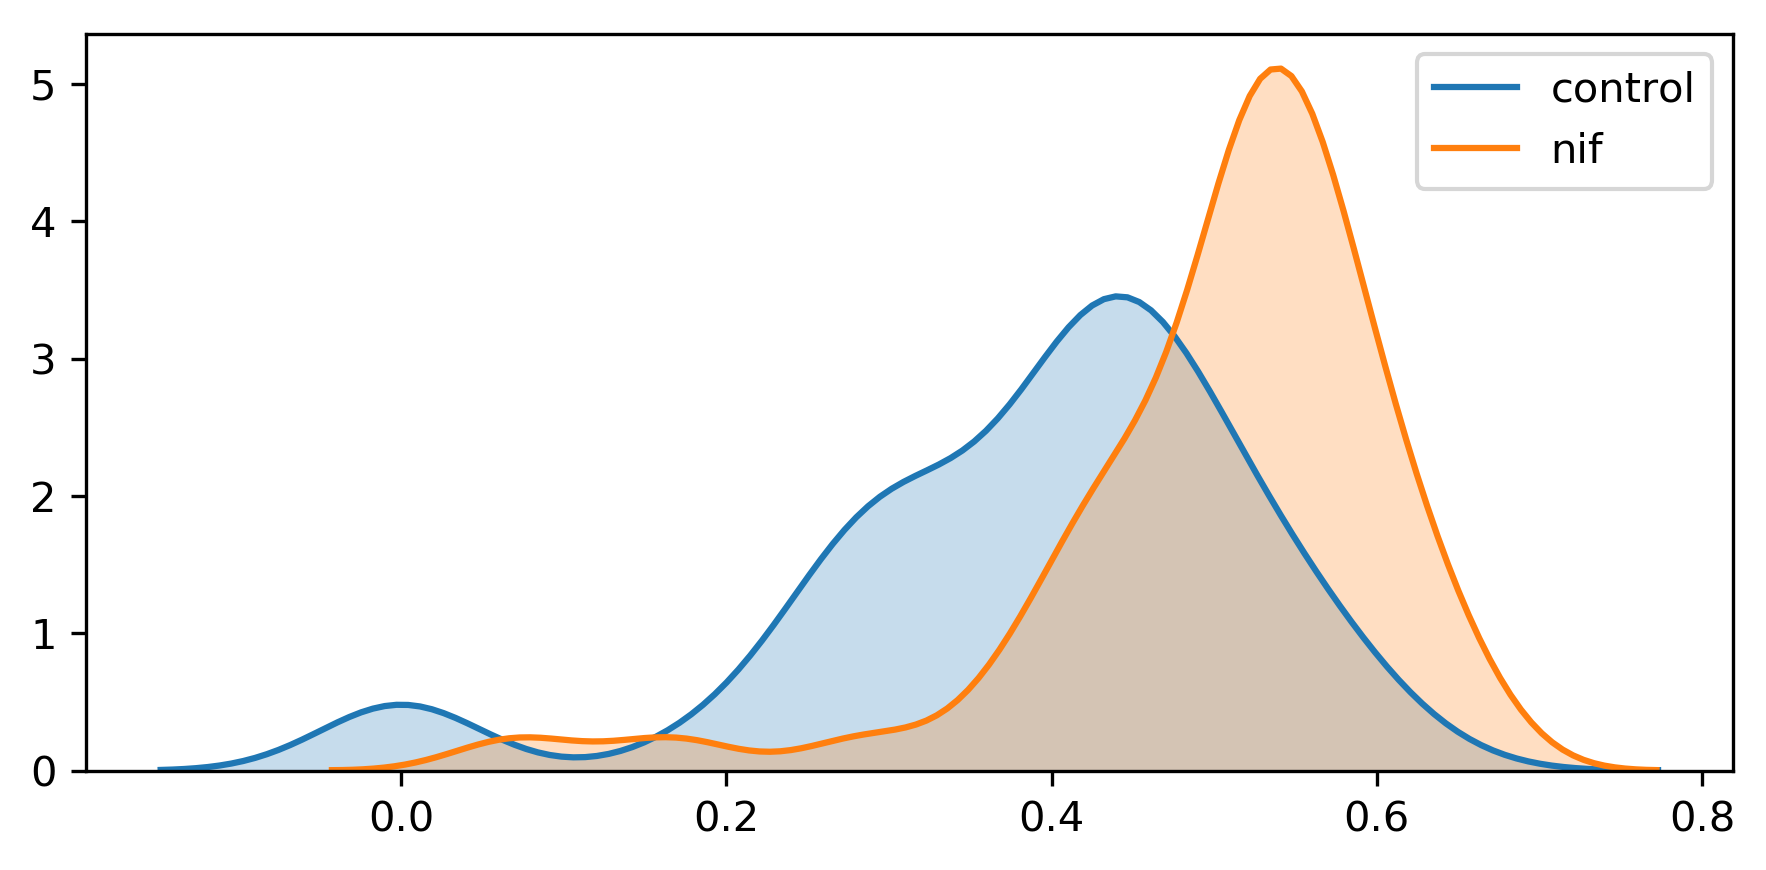

In [384]:
num_of_ctrl_branches = 34830.0
num_of_nif_branches  = 5876.0
ctrl_frequency = pkl.load(open('control_transfer_frequence.pkl'))
nif_frequency   = pkl.load(open('nif_transfer_frequence.pkl'))
fig, ax = plt.subplots()
sns.kdeplot(ctrl_frequency.values(), ax=ax, shade=True, label='control')
sns.kdeplot(nif_frequency.values(), ax=ax, shade=True, label='nif')
fig.set_size_inches(6,3)
fig.set_dpi(300)
fig.tight_layout()
print ttest_ind(ctrl_frequency.values(), nif_frequency.values())

In [23]:
ctrl_transfers = pkl.load(open('control_transfers.pkl'))
ctrl_pairs     = []
ctrl_nodes     = []
out = open('control_pairs.constrains', 'w')
for group, pairs in ctrl_transfers.items():
    for donor, recipient in pairs:
        out.write('%s\t%s\n' % (donor, recipient))
        ctrl_pairs.append(frozenset([donor, recipient]))
        ctrl_nodes.append(donor)
        ctrl_nodes.append(recipient)
out.close()

nif_transfers = pkl.load(open('nif_transfers.pkl'))
nif_pairs     = []
nif_nodes     = []
out = open('nif_pairs.constrains', 'w')
for group, pairs in nif_transfers.items():
    for donor, recipient in pairs:
        out.write('%s\t%s\n' % (donor, recipient))
        nif_pairs.append(frozenset([donor, recipient]))
        nif_nodes.append(donor)
        nif_nodes.append(recipient)
out.close()

shared_pairs = 0
for common_pair in set(nif_pairs).intersection(ctrl_pairs):
    shared_pairs += nif_pairs.count(common_pair)
    shared_pairs += ctrl_pairs.count(common_pair)
    
shared_nodes = 0
for common_node in set(nif_nodes).intersection(ctrl_nodes):
    shared_nodes += nif_nodes.count( common_node)
    shared_nodes += ctrl_nodes.count(common_node)

In [226]:
out = open('control_constraints', 'w')
for donor, recipient in ctrl_pairs:
    out.write('%s\t%s\n' %(donor, recipient))
out.close()
out = open('nif_constraints', 'w')
for donor, recipient in nif_pairs:
    out.write('%s\t%s\n' %(donor, recipient))
out.close()

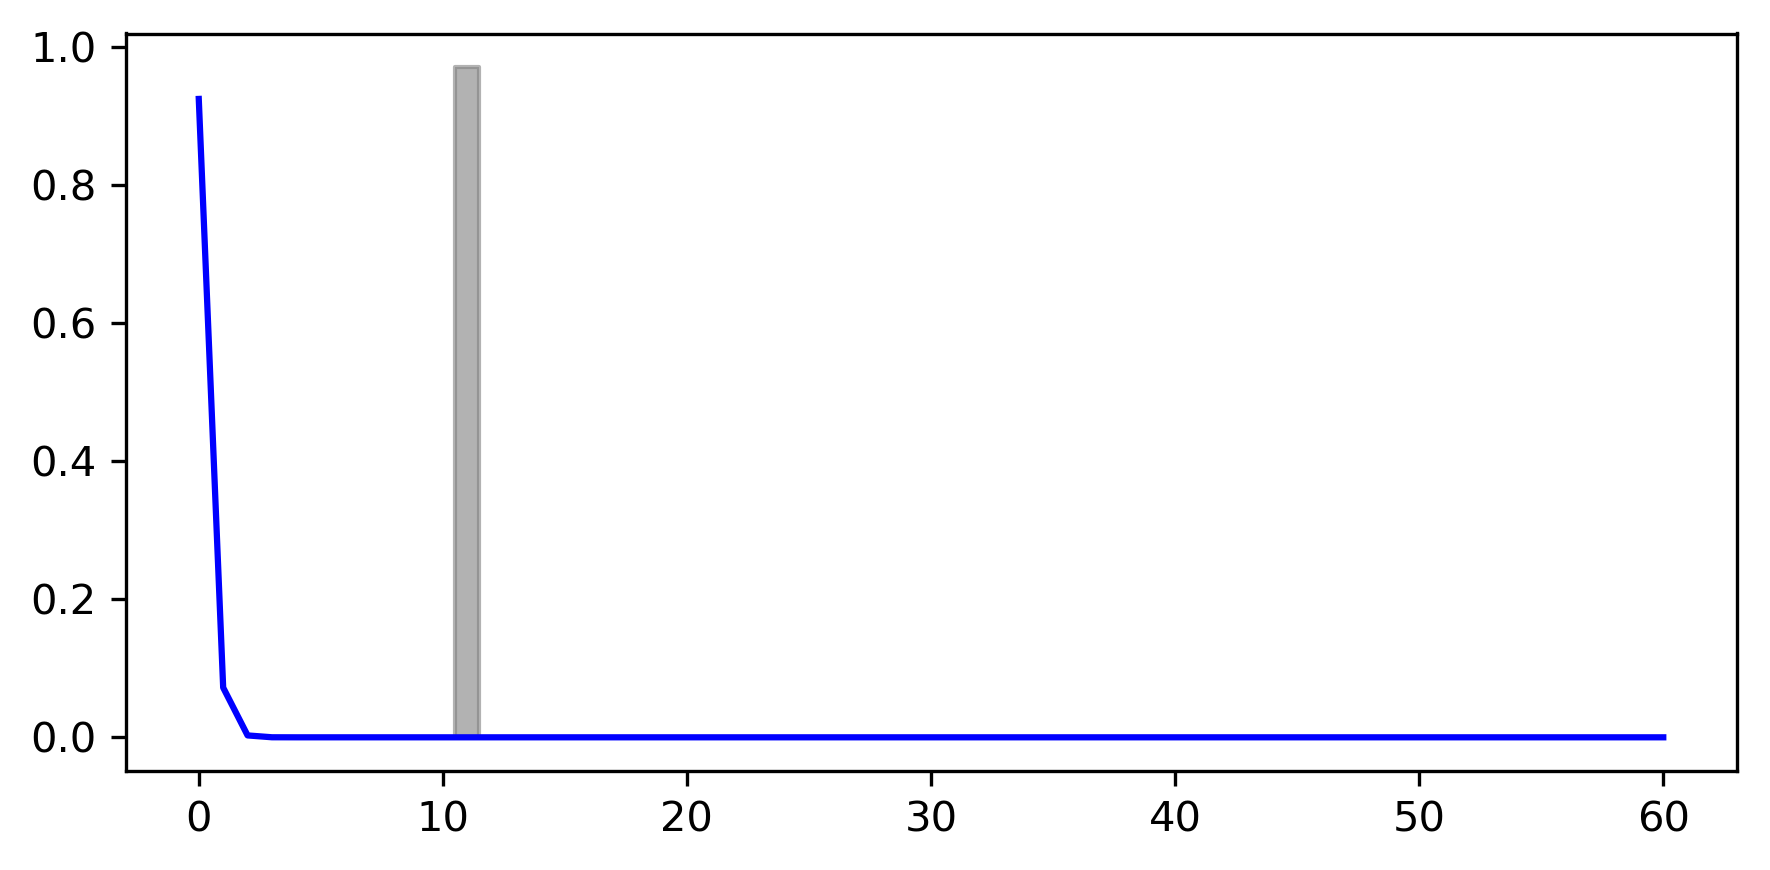

In [55]:
total_combinations    = math.factorial(956)/(2*math.factorial(956-2))
observed_combinations = set(nif_pairs).union(ctrl_pairs)
intersection = len(set(nif_pairs).intersection(ctrl_pairs))
rv = hypergeom(total_combinations, len(set(nif_pairs)), len(set(ctrl_pairs)))
x  = np.arange(len(set(nif_pairs).intersection(ctrl_pairs))+50)
y  = rv.pmf(x)
fig, ax = plt.subplots()
ax.plot(x, y, 'b-')
ax.fill_between(x=[intersection-0.5, intersection+0.5], y1=ax.get_ybound()[1], color='grey', alpha=0.6)
fig.set_size_inches(6,3)
fig.set_dpi(300)
fig.tight_layout()

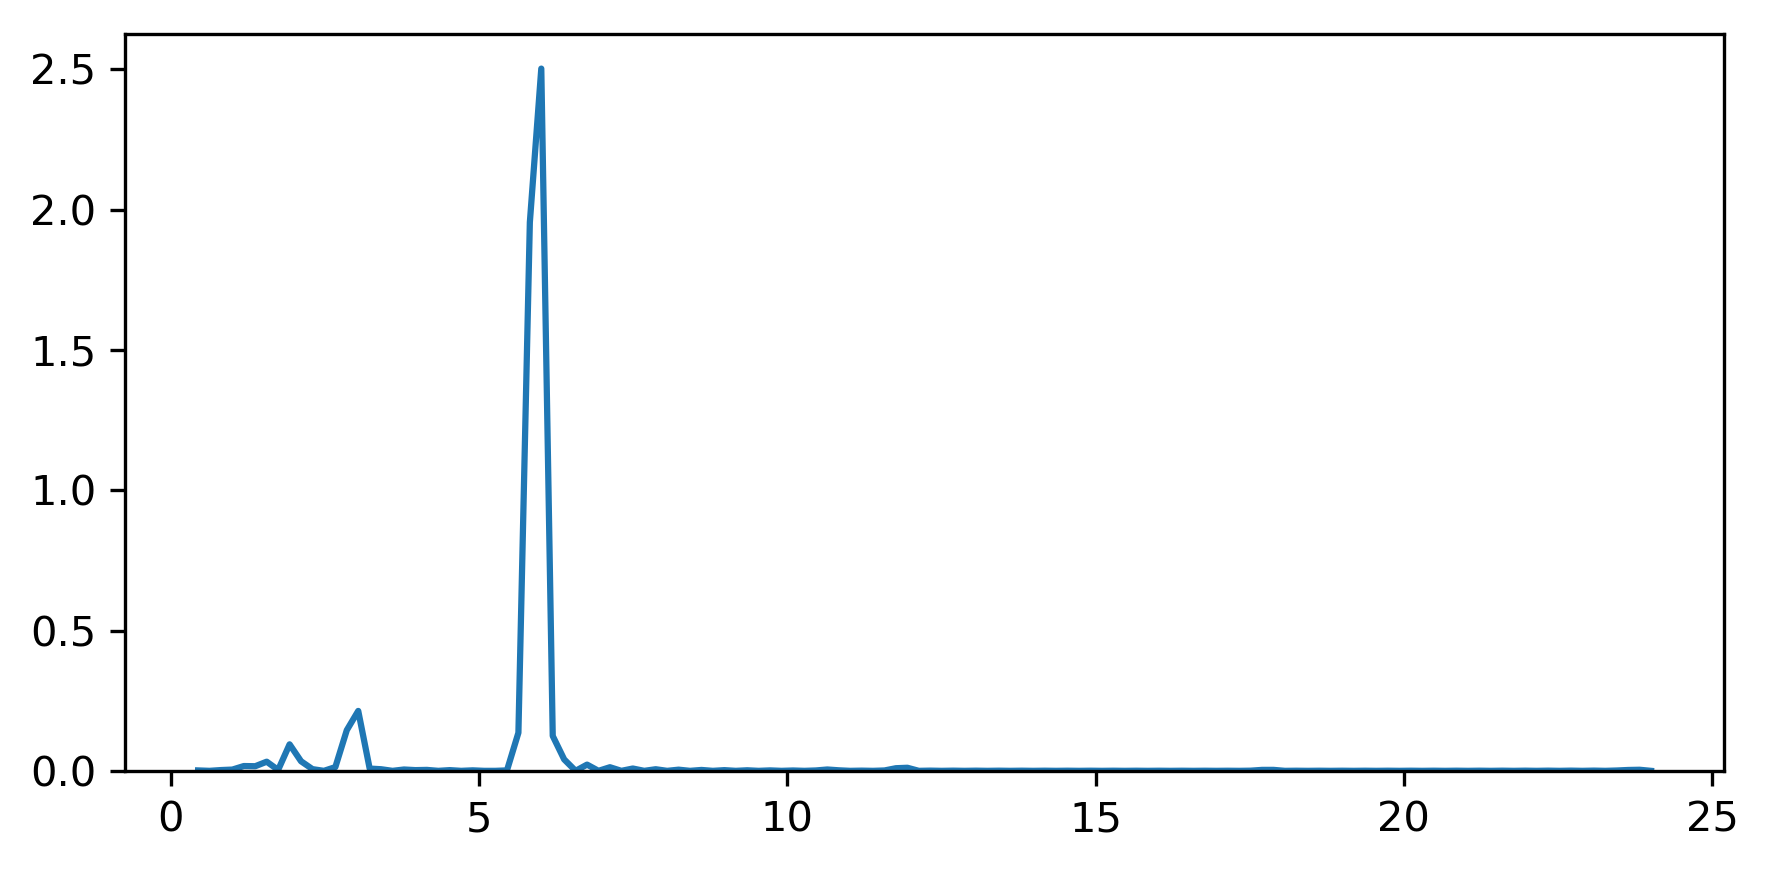

In [508]:
ctrl_node_count = collections.Counter(ctrl_pairs)
nif_node_count  = collections.Counter(nif_pairs)
node_count_ratio = {node:(nif_node_count[node]/num_of_nif_branches)/(ctrl_node_count[node]/num_of_ctrl_branches)
                    if node in ctrl_node_count else (nif_node_count[node]/num_of_nif_branches)/(1.0/num_of_ctrl_branches)
                    for node in nif_node_count.keys()}
node_count_ratio.update({
    node:(1.0/num_of_nif_branches)/(ctrl_node_count[node]/num_of_ctrl_branches)
    for node in ctrl_node_count.keys()
    if not node in nif_node_count})
fig, ax = plt.subplots()
sns.kdeplot(node_count_ratio.values(), bw=0.1)
fig.set_size_inches(6,3)
fig.set_dpi(300)
fig.tight_layout()

In [95]:
len(node_count_ratio)

78

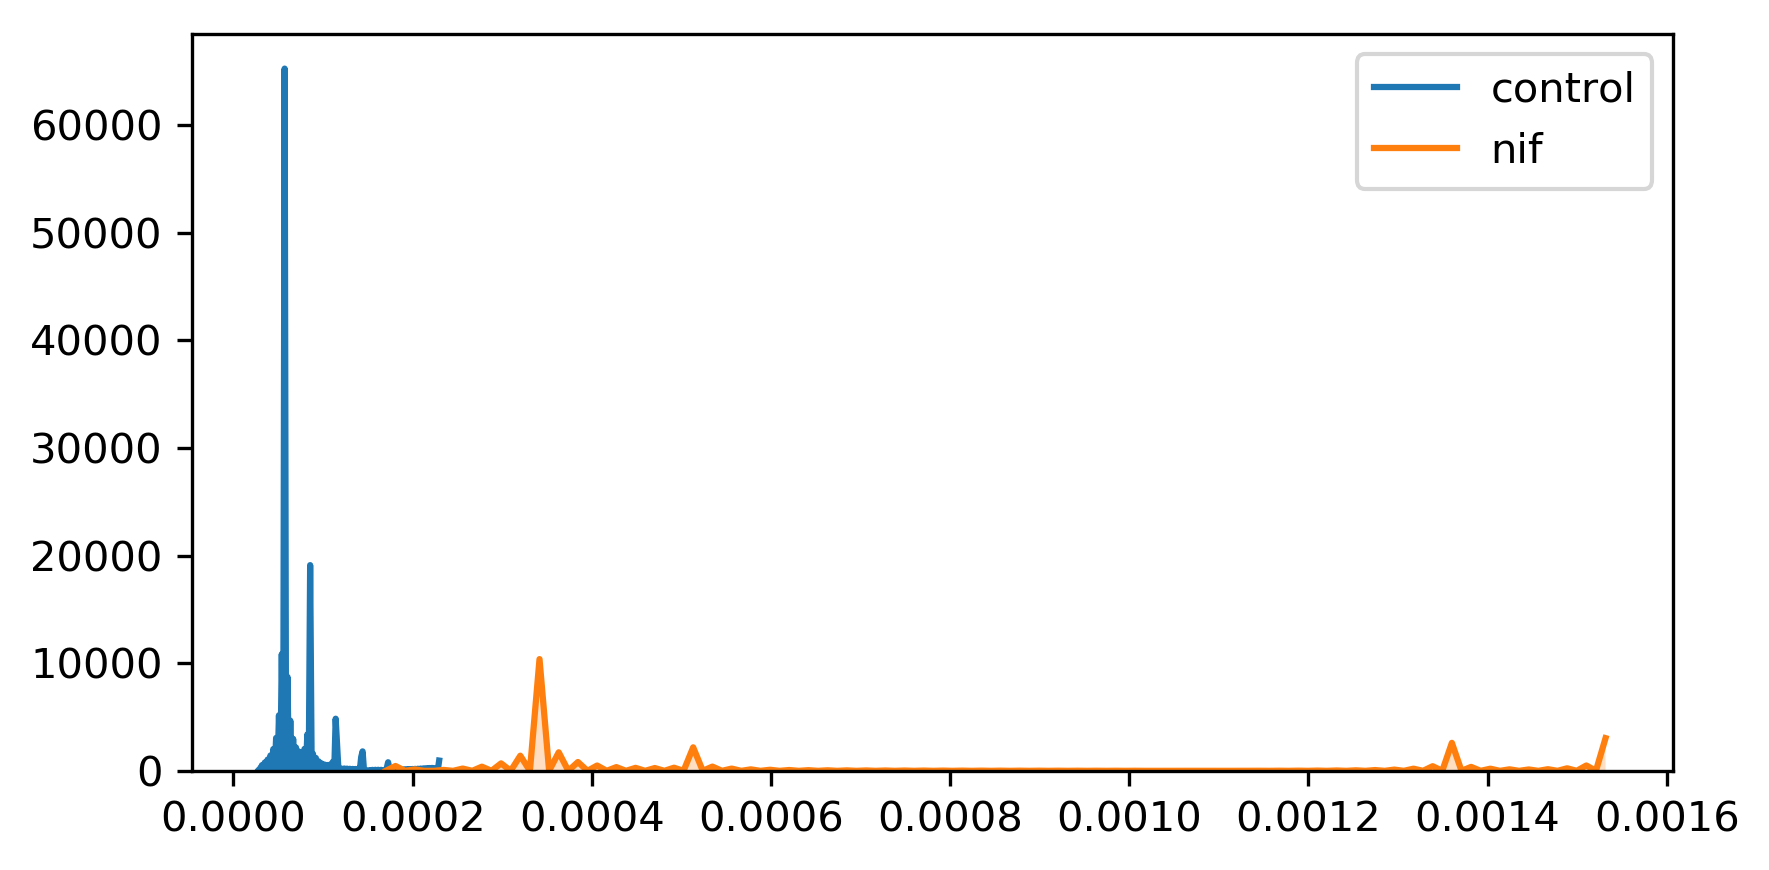

In [386]:
fig, ax = plt.subplots()
sns.kdeplot([count/num_of_ctrl_branches for count in ctrl_node_count.values()], label='control', shade=True)
sns.kdeplot([count/num_of_nif_branches for count in nif_node_count.values()], label='nif', shade=True)
fig.set_size_inches(6,3)
fig.set_dpi(300)
fig.tight_layout()

<h1>Test if inter class transfers are enriched in the control set</h1>

In [319]:
class_nodes = {}
for leaf, taxa in ncbi.get_lineage_translator(tree.get_leaf_names()).items():
    lineage       = {j: i for i, j in ncbi.get_rank(taxa).items()}
    lineage_names = ncbi.get_taxid_translator(taxa)
    
    taxon_class       = lineage_names[lineage['class']]
    class_nodes[str(leaf)] = taxon_class

In [320]:
for node in tree.traverse():
    if node.is_root() or node.is_leaf():
        continue
    
    present_classes = set([class_nodes[leaf] for leaf in node.get_leaf_names()])
    if len(present_classes) > 1:
        continue
    else:
        class_nodes[node.name] = present_classes.pop()

In [553]:
pair

'Betaproteobacteria'

In [574]:
assessed_classes   = 'Betaproteobacteria Gammaproteobacteria Epsilonproteobacteria Alphaproteobacteria Deltaproteobacteria'.split()
class_combinations = {frozenset(pair):0 for pair in itertools.combinations(assessed_classes, 2)}
class_combinations.update({key:0 for key in assessed_classes})

class_hgt_frequency = pd.DataFrame(columns='class_pair frequency gene_set'.split())
for pair in nif_pairs:
    taxa_classes = [class_nodes[node] if node in class_nodes and class_nodes[node] in assessed_classes else False for node in pair]
    if not all(taxa_classes):
        continue
    if len(set(taxa_classes)) == 2:
        class_combinations[frozenset(taxa_classes)] += 1
    elif len(set(taxa_classes)) == 1:
        class_combinations[taxa_classes[0]] += 1

for pair, count in class_combinations.items():
    normalization_value = 0.0
    if type(pair) is str:
        normalization_value += class_count['nif'][taxon]
    else:
        for taxon in set(pair):
            normalization_value += class_count['nif'][taxon]
    print pair, count/normalization_value
    class_hgt_frequency = class_hgt_frequency.append(
    pd.DataFrame(
        [[pair, count/normalization_value, 'nif']],
        columns='class_pair frequency gene_set'.split()),
        ignore_index=True)

frozenset(['Alphaproteobacteria', 'Deltaproteobacteria']) 0.0
frozenset(['Epsilonproteobacteria', 'Gammaproteobacteria']) 0.000924214417745
Betaproteobacteria 0.0222469410456
Gammaproteobacteria 0.00333704115684
frozenset(['Betaproteobacteria', 'Deltaproteobacteria']) 0.00314795383001
frozenset(['Betaproteobacteria', 'Gammaproteobacteria']) 0.0
frozenset(['Betaproteobacteria', 'Epsilonproteobacteria']) 0.00243309002433
frozenset(['Epsilonproteobacteria', 'Alphaproteobacteria']) 0.0
Epsilonproteobacteria 0.01443001443
frozenset(['Epsilonproteobacteria', 'Deltaproteobacteria']) 0.0120724346076
frozenset(['Alphaproteobacteria', 'Gammaproteobacteria']) 0.000628140703518
frozenset(['Gammaproteobacteria', 'Deltaproteobacteria']) 0.0
Alphaproteobacteria 0.0445859872611
frozenset(['Betaproteobacteria', 'Alphaproteobacteria']) 0.0015015015015
Deltaproteobacteria 0.011544011544


In [575]:
assessed_classes   = 'Betaproteobacteria Gammaproteobacteria Epsilonproteobacteria Alphaproteobacteria Deltaproteobacteria'.split()
class_combinations = {frozenset(pair):0 for pair in itertools.combinations(assessed_classes, 2)}
class_combinations.update({key:0 for key in assessed_classes})

for pair in ctrl_pairs:
    taxa_classes = [class_nodes[node] if node in class_nodes and class_nodes[node] in assessed_classes else False for node in pair]
    if not all(taxa_classes):
        continue
    if len(set(taxa_classes)) == 2:
        class_combinations[frozenset(taxa_classes)] += 1
    elif len(set(taxa_classes)) == 1:
        class_combinations[taxa_classes[0]] += 1 

for pair, count in class_combinations.items():
    normalization_value = 0.0
    if type(pair) is str:
        normalization_value += class_count['ctrl'][taxon]
    else:
        for taxon in set(pair):
            normalization_value += class_count['ctrl'][taxon]
    print pair, count/normalization_value
    class_hgt_frequency = class_hgt_frequency.append(
        pd.DataFrame(
            [[pair, count/normalization_value, 'control']],
            columns='class_pair frequency gene_set'.split()),
    ignore_index=True)

frozenset(['Alphaproteobacteria', 'Deltaproteobacteria']) 0.002125
frozenset(['Epsilonproteobacteria', 'Gammaproteobacteria']) 0.00185744137451
Betaproteobacteria 0.0417036379769
Gammaproteobacteria 0.0417036379769
frozenset(['Betaproteobacteria', 'Deltaproteobacteria']) 0.000920979922638
frozenset(['Betaproteobacteria', 'Gammaproteobacteria']) 0.00354838709677
frozenset(['Betaproteobacteria', 'Epsilonproteobacteria']) 0.000801068090788
frozenset(['Epsilonproteobacteria', 'Alphaproteobacteria']) 0.000158328055731
Epsilonproteobacteria 0.00649350649351
frozenset(['Epsilonproteobacteria', 'Deltaproteobacteria']) 0.00226244343891
frozenset(['Alphaproteobacteria', 'Gammaproteobacteria']) 0.00228024170562
frozenset(['Gammaproteobacteria', 'Deltaproteobacteria']) 0.00300450676014
Alphaproteobacteria 0.083908045977
frozenset(['Betaproteobacteria', 'Alphaproteobacteria']) 0.00243635034718
Deltaproteobacteria 0.0307977736549


yeah


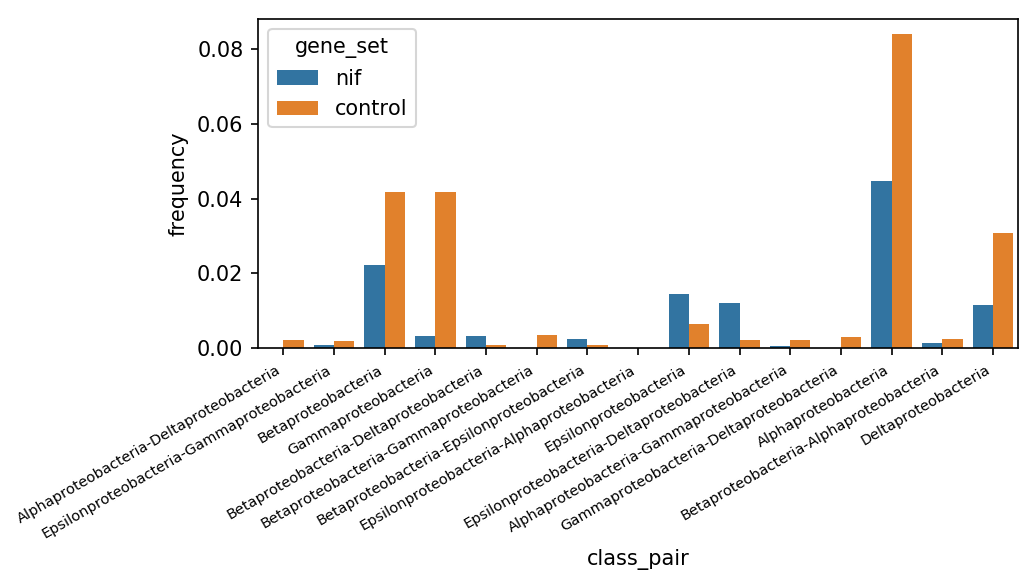

In [576]:
fig, ax = plt.subplots()
sns.barplot(x='class_pair', y='frequency', hue='gene_set', data=class_hgt_frequency, ax=ax)
ax.set_xticklabels(['-'.join(pair) if not type(pair) is str else pair for pair in class_hgt_frequency['class_pair'].unique()],
                   rotation=30,
                  ha='right',
                  fontsize=7)
fig.set_size_inches(7,4)
fig.set_dpi(150)
fig.tight_layout()
print 'yeah'

In [597]:
grouped = class_hgt_frequency.groupby('class_pair')
inter, intra = [],[]
for key, indexes in grouped.groups.items():
    ratio = class_hgt_frequency.iloc[indexes].frequency.values[0]/class_hgt_frequency.iloc[indexes].frequency.values[1]
    if type(key) is str:
        intra.append(ratio)
    else:
        if 'Epsilonproteobacteria' in key:
            continue
        inter.append(ratio)
    print key, ratio

frozenset(['Alphaproteobacteria', 'Deltaproteobacteria']) 0.0
Betaproteobacteria 0.5334532459233664
Gammaproteobacteria 0.08001798688850496
frozenset(['Betaproteobacteria', 'Deltaproteobacteria']) 3.4180482686253937
frozenset(['Betaproteobacteria', 'Gammaproteobacteria']) 0.0
Epsilonproteobacteria 2.222222222222222
frozenset(['Alphaproteobacteria', 'Gammaproteobacteria']) 0.2754711055276382
frozenset(['Gammaproteobacteria', 'Deltaproteobacteria']) 0.0
frozenset(['Betaproteobacteria', 'Alphaproteobacteria']) 0.6162912912912913
Alphaproteobacteria 0.531367245441061
Deltaproteobacteria 0.3748326639892905


In [598]:
print inter
print intra

[0.0, 3.4180482686253937, 0.0, 0.2754711055276382, 0.0, 0.6162912912912913]
[0.5334532459233664, 0.08001798688850496, 2.222222222222222, 0.531367245441061, 0.3748326639892905]


In [502]:
proteo = pd.read_table('proteo_info.tab', index_col=0, dtype=dict(taxid=str))
genome_cluster = pkl.load(open('shared_origin_clusters.pkl'))
for i,j in genome_cluster.items():
    print i, proteo.loc[j, 'class'].unique()

0 ['Gammaproteobacteria' 'Betaproteobacteria' 'Alphaproteobacteria'
 'Zetaproteobacteria']
1 ['Deltaproteobacteria']
2 ['Gammaproteobacteria' 'Alphaproteobacteria']
3 ['Betaproteobacteria']
4 ['Epsilonproteobacteria']


<h1>Test if inter cluster transfers are enriched in the nif set</h1>

In [366]:
proteo = pd.read_table('proteo_info.tab', index_col=0, dtype=dict(taxid=str))
genome_cluster = pkl.load(open('shared_origin_clusters.pkl'))
genome_cluster = {proteo.loc[genome, 'taxid']:cluster_num for cluster_num, genomes in genome_cluster.items() for genome in genomes}

for node in tree.traverse():
    if node.is_root() or node.is_leaf():
        continue
    
    present_clusters = set([genome_cluster[leaf] for leaf in node.get_leaf_names() if leaf in genome_cluster])
    if len(present_clusters) != 1:
        continue
    else:
        genome_cluster[node.name] = present_clusters.pop()

In [381]:
cluster_combinations = {frozenset(list(pair)):0 for pair in itertools.combinations(set(genome_cluster.values()), 2)}
within_clusters      = {cluster_number:0 for cluster_number in set(genome_cluster.values())}
for pair in nif_pairs:
    taxa_cluster = [genome_cluster[node] if node in genome_cluster else False for node in pair]
    if not all(taxa_cluster):
        continue
    if len(set(taxa_cluster)) == 1:
        within_clusters[taxa_cluster[0]] += 1
    elif len(set(taxa_cluster)) == 2:
        cluster_combinations[frozenset(taxa_cluster)] += 1
cluster_combinations
within_clusters

{0: 0, 1: 7, 2: 11, 3: 10, 4: 8}

In [380]:
cluster_combinations = {frozenset(list(pair)):0 for pair in itertools.combinations(set(genome_cluster.values()), 2)}
for pair in ctrl_pairs:
    taxa_cluster = [genome_cluster[node] if node in genome_cluster else False for node in pair]
    if not all(taxa_cluster):
        continue
    if len(set(taxa_cluster)) == 1:
        within_clusters[taxa_cluster[0]] += 1
    elif len(set(taxa_cluster)) == 2:
        cluster_combinations[frozenset(taxa_cluster)] += 1
cluster_combinations
within_clusters

{0: 0, 1: 74, 2: 87, 3: 26, 4: 14}

In [485]:
genome_cluster

{'1006551': 0,
 '1037409': 2,
 '1064539': 2,
 '1116375': 0,
 '1121032': 0,
 '1121035': 0,
 '1123487': 0,
 '1150469': 2,
 '1151116': 0,
 '1188231': 0,
 '137722': 2,
 '156889': 0,
 '159087': 0,
 '177437': 1,
 '198628': 0,
 '216596': 2,
 '218491': 0,
 '243159': 2,
 '243233': 0,
 '266265': 3,
 '266835': 2,
 '269482': 3,
 '269796': 2,
 '272568': 2,
 '272942': 2,
 '273121': 4,
 '288000': 2,
 '322710': 0,
 '335543': 1,
 '338963': 1,
 '342108': 2,
 '347834': 2,
 '349124': 0,
 '365044': 3,
 '366394': 2,
 '377629': 0,
 '391038': 3,
 '394': 2,
 '395495': 3,
 '395960': 2,
 '395963': 2,
 '395965': 2,
 '426117': 2,
 '438753': 2,
 '439235': 1,
 '460265': 2,
 '507522': 0,
 '522306': 0,
 '525897': 1,
 '526222': 1,
 '536019': 2,
 '557760': 2,
 '572477': 0,
 '572480': 4,
 '573370': 1,
 '577650': 1,
 '580332': 0,
 '589865': 1,
 '592316': 0,
 '595494': 0,
 '622759': 2,
 '62928': 0,
 '640081': 3,
 '640131': 0,
 '641491': 1,
 '643562': 1,
 '644282': 1,
 '648757': 2,
 '690850': 1,
 '706587': 1,
 '707241': 2,


In [357]:
cluster_combinations = {frozenset(pair):0 for pair in itertools.combinations(genome_cluster.values(), 2)}
for pair in nif_pairs:
    taxa_classes = [genome_cluster[node] if node in class_nodes and class_nodes[node] in assessed_classes else False for node in pair]
    if not all(taxa_classes):
        continue
    if len(set(taxa_classes)) == 2:
        class_combinations[frozenset(taxa_classes)] += 1
class_combinations

In [383]:
pkl.load(open('shared_origin_clusters.pkl'))

{0: ['Methylomonas_methanica',
  'Methylococcus_capsulatus',
  'Sideroxydans_lithotrophicus',
  'Azoarcus_sp',
  'Klebsiella_variicola',
  'Candidatus_Accumulibacter_phosphatis',
  'Tolumonas_auensis',
  'Uliginosibacterium_gangwonense_DSM_18521',
  'Azovibrio_restrictus_DSM_23866',
  'Klebsiella_oxytoca',
  'Pseudomonas_stutzeri',
  'Rahnella_aquatilis',
  'Azotobacter_vinelandii',
  'Allochromatium_vinosum',
  'Dickeya_dadantii',
  'Klebsiella_pneumoniae',
  'Halorhodospira_halophila',
  'Magnetococcus_marinus',
  'Teredinibacter_turnerae',
  'Pantoea_sp',
  'Dechloromonas_aromatica',
  'Thiocystis_violascens',
  'Mariprofundus_ferrooxydans_M34',
  'Azonexus_hydrophilus_DSM_23864',
  'Pectobacterium_atrosepticum',
  'Vibrio_sp'],
 1: ['Syntrophobacter_fumaroxidans',
  'Desulfomonile_tiedjei',
  'Desulfobacca_acetoxidans',
  'Desulfurivibrio_alkaliphilus',
  'Desulfomicrobium_baculatum',
  'Desulfovibrio_salexigens',
  'Pelobacter_carbinolicus',
  'Desulfobacterium_autotrophicum',
  '

frozenset(['n10', '760154']) 8.51063829787


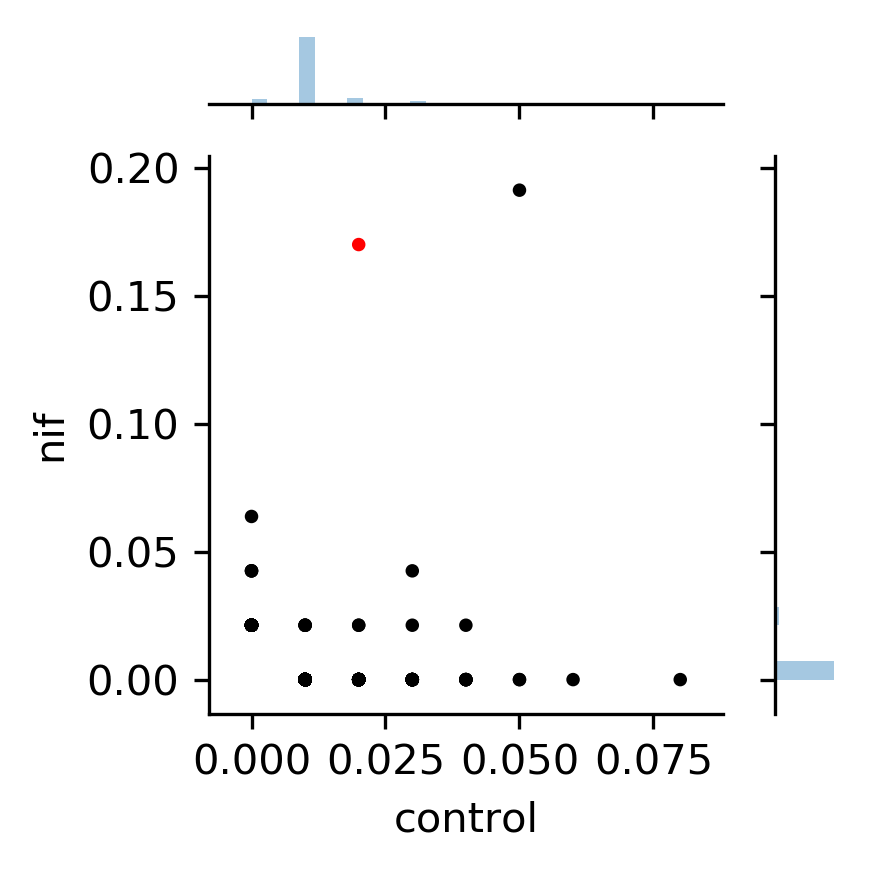

In [206]:
x      = []
y      = []
color  = []
ratios = []
p_val  = []
nodes  = []
for node,value in node_count_ratio.items():
    x_value  = ctrl_node_count[node]/100.0
    p_enrich = binom_test(nif_node_count[node], 47, p=x_value if x_value else 0.01)
    x.append(x_value)
    y.append(nif_node_count[node]/47.0)
    ratios.append(value)
    p_val.append(p_enrich)
    nodes.append(node)

reject, corrected, alphacSidak, alphacBonf = multipletests(p_val, alpha=0.05)
for node, rejected, ratio in zip(nodes, reject, ratios):
    if rejected and ratio > 1:
        print node, ratio
        color.append('red')
    elif rejected and ratio < 1:
        color.append('blue')
    else:
        color.append('black')
        
fig = sns.jointplot(x=pd.Series(x, name='control'), y=pd.Series(y, name='nif'), joint_kws=dict(color=color), s=5)
fig.fig.set_size_inches(3,3)
fig.fig.set_dpi(300)
fig.fig.tight_layout()

In [282]:
yeah = ncbi.get_taxid_translator([630626])
print yeah.values()[0]
for taxon in ncbi.get_lineage_translator(yeah.keys()).values()[0]:
    print ncbi.get_taxid_translator([taxon])

Shimwellia blattae DSM 4481 = NBRC 105725
{1: u'root'}
{131567: u'cellular organisms'}
{2: u'Bacteria'}
{1224: u'Proteobacteria'}
{1236: u'Gammaproteobacteria'}
{91347: u'Enterobacterales'}
{543: u'Enterobacteriaceae'}
{1335483: u'Shimwellia'}
{563: u'Shimwellia blattae'}
{630626: u'Shimwellia blattae DSM 4481 = NBRC 105725'}


In [270]:
node = tree.search_nodes(name='n165')[0]
node.get_leaf_names()

['375451', '391595']

In [263]:
for node,value in sorted(node_count_ratio.items(), key=operator.itemgetter(1), reverse=False):
    if value < 1 and ctrl_node_count[node] > 1:
        print node, round(value, 3), nif_node_count[node], ctrl_node_count[node]

frozenset(['393305', 'n387']) 0.125 0 8
frozenset(['n165', '290400']) 0.167 0 6
frozenset(['266835', '536019']) 0.2 0 5
frozenset(['204722', '483179']) 0.2 0 5
frozenset(['448385', 'n37']) 0.25 0 4
frozenset(['n240', 'n231']) 0.25 0 4
frozenset(['525897', '573370']) 0.25 0 4
frozenset(['387093', '563040']) 0.25 0 4
frozenset(['391165', 'n83']) 0.25 0 4
frozenset(['630626', '218491']) 0.25 0 4
frozenset(['290338', '637910']) 0.333 0 3
frozenset(['n10', 'n5']) 0.333 0 3
frozenset(['365046', '543728']) 0.333 0 3
frozenset(['573370', '526222']) 0.333 0 3
frozenset(['748280', '267608']) 0.333 0 3
frozenset(['56780', 'n66']) 0.333 0 3
frozenset(['351605', '243231']) 0.333 0 3
frozenset(['1121035', '640081']) 0.333 0 3
frozenset(['398767', 'n44']) 0.333 0 3
frozenset(['880072', '706587']) 0.333 0 3
frozenset(['399804', '399599']) 0.333 0 3
frozenset(['557760', '318586']) 0.333 0 3
frozenset(['365044', '420662']) 0.333 0 3
frozenset(['690850', '573370']) 0.333 0 3
frozenset(['279238', '702113'

In [222]:
for node,value in sorted(node_count_ratio.items(), key=operator.itemgetter(1), reverse=True):
    if nif_node_count[node] >= 2:
        print node, round(value, 3), nif_node_count[node], ctrl_node_count[node]

frozenset(['n10', '760154']) 8.511 8 2
frozenset(['414684', 'n80']) 6.383 3 0
frozenset(['n41', 'n284']) 4.255 2 0
frozenset(['598659', '760142']) 4.255 2 0
frozenset(['338963', 'n7']) 4.255 2 0
frozenset(['391038', '977880']) 3.83 9 5
frozenset(['n141', '216596']) 1.418 2 3


In [181]:
for node in '760154 757424 n7 391038 977880 n80 338963'.split():
    print node
    partners = []
    for pair in nif_pairs:
        pair = list(pair)
        if node in pair:
            if pair[0] == node:
                partners.append(pair[1])
            else:
                partners.append(pair[0])
    print collections.Counter(partners)

760154
Counter({'n10': 8})
757424
Counter({'395963': 1, '522306': 1})
n7
Counter({'338963': 2, 'n284': 1, '760142': 1})
391038
Counter({'977880': 9, '338969': 1, '269482': 1})
977880
Counter({'391038': 9})
n80
Counter({'414684': 3})
338963
Counter({'n7': 2, '273121': 1})
